# WS 1.2: Mean and Variance Propagation

**Sewer Pipe Flow Velocity**

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.2. Wed Sep 11, 2024.*

## Overview

In this notebook you will apply the propagation laws for the mean and variance for a function of two independent random variables. You will assess how well the approximations correspond with the <em>simulation-based</em> equivalents. You will also assess the distribution of the function.

_You do not need to turn in this notebook._

### Objectives

1. Observe how uncertainty "propagates" from the inputs to the output of a function by estimating moments of the function of random variables and seeing how they change relative to the moments of the input random variables.
2. Recognize that a non-linear function of random variables that have the (joint) Normal distribution (the inputs) produces a non-Normal random variable (the output).
3. Using _sampling_ (Monte Carlo Simulation) to _validate_ the linearized error propagation technique introduced in the textbook. Specifically, by:
   1. Comparing the estimated moments with that of the sample, and
   2. Comparing the Normal distribution defined by the estimated moments to the sample

### A Note on "Sampling"

We will use Monte Carlo Simulation to create an empirical "sample" of the random values of our function of random variables, $V$ (the output). This is a commonly used approach widely used in science and engineering applications. It is a numerical way of computing the distribution of a function that is useful when analytic approaches are not possible (for example, when the input distributions are non-Normal or the function is non-linear). For our purposes today, Monte Carlo Simulation is quite simple and involves the following steps:

1. Define a function of random variables and the distributions of its input parameters.
2. Create a random sample of each input parameter according to the specified distribution.
3. Create a random sample of the output variable by computing the function for every set of input samples.
4. Evaluate the resulting distribution of the output.

A few key points to recognize are:
1. As the sample size increases, the resulting distribution becomes more accurate.
2. This is a way to get the (approximately) "true" distribution of a function of random variables.
3. Accuracy is relative to the propagation of uncertainty through the function based on the assumed distributions of the input random variables. In other words, MCS can't help you if your function and distributions are poor representations of reality!

### Application: Sewer Pipe Flow Velocity

We will apply Manning's formula for the flow velocity $V$ in a sewer:

$$
V =\frac{1}{n}R^{2/3}S^{1/2}
$$

where $R$ is the hydraulic radius of the sewer pipe (in $m$), $S$ the slope of the pipe (in $m/m$), and $n$ is the coefficient of roughness [$-$].

Both $R$ and $S$ are random variables, as it is known that sewer pipes are susceptible to deformations; $n$ is assumed to be deterministic and in our case $n=0.013$ $s/m^{1/3}$. The sewer pipe considered here has mean values $\mu_R$, $\mu_S$, and standard deviations $\sigma_R$ and $\sigma_S$; $R$ and $S$ are independent.

We are now interested in the mean flow velocity in the sewer as well as the uncertainty expressed by the standard deviation. This is important for the design of the sewer system.

*Disclaimer: the dimensions of the pipe come from a real case study, but some aspects of the exercise are...less realistic.*

### Programming

Remember to use your `mude-base` environment when running this notebook.

Some of the functions below uses <em>keyword arguments</em> to specify some of the parameter values; this is a way of setting "default" values. You can override them when using the function by specifying an alternative syntax. For example, the function here can be used in the following way to return `x=5` and `x=6`, respectively:

```python
def test(x=5)
    return x
   
print(test())
print(test(x=6))
```
Copy/paste into a cell to explore further!

Note also in the cell below that we can increase the default size of the text in our figures to make them more readable!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

import ipywidgets as widgets
from ipywidgets import interact

plt.rcParams.update({'font.size': 14})

### Theory: Propagation laws for a function of 2 random variables 

We are interested in the mean and variance of $X$, which is a function of 2 random variables: $X=q(Y_1,Y_2)$. The mean and covariance matrix of $Y$ are assumed to be known:

$$\mu_Y = [\mu_1\;\mu_2]^T$$

$$\Sigma_Y = \begin{bmatrix} \sigma^2_1 & Cov(Y_1,Y_2) \\ Cov(Y_1,Y_2) & \sigma^2_2\end{bmatrix}$$

The second-order Taylor series approximation of the mean $\mu_X$ is then given by:

$$\mu_X=\mathbb{E}(q(Y))\approx q(\mu_Y )+\frac{1}{2}\frac{\partial^2 q(\mu_Y )}{\partial Y_1^2 } \sigma_1^2+\frac{1}{2}\frac{\partial^2 q(\mu_Y )}{\partial Y_2^2 }\sigma_2^2+\frac{\partial^2 q(\mu_Y )}{\partial Y_1 \partial Y_2 } Cov(Y_1,Y_2) $$

In most practical situations, the second-order approximation suffices. 

For the variance $\sigma_X^2$ it is common to use only the first-order approximation, given by:

$$\sigma^2_X \approx \left(\frac{\partial q(\mu_Y )}{\partial Y_1 } \right)^2 \sigma^2_1 +\left(\frac{\partial q(\mu_Y )}{\partial Y_2 } \right)^2 \sigma^2_2 + 2\left(\frac{\partial q(\mu_Y )}{\partial Y_1 } \right) \left(\frac{\partial q(\mu_Y )}{\partial Y_2 } \right)  Cov(Y_1,Y_2)$$

## Part 1: Apply the Propagation Laws

We are interested to know how the uncertainty in $R$ and $S$ propagates into the uncertainty of the flow velocity $V$. We will first do this analytically and then implement it in code.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   

Use the Taylor series approximation to find the expression for $\mu_V$ and $\sigma_V$ as function of $\mu_R$, $\sigma_R$, $\mu_S$, $\sigma_S$. Write your answer on paper or using a tablet; later we will learn how to include images directly in our notebooks! For now you can skip this step, as you are not turning this notebook in.
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2:</b>   

Complete the function below, such that <code>moments_of_taylor_approximation</code> will compute the approximated $\mu_V$ and $\sigma_V$, as found in the previous Task.
</p>
</div>

In [2]:
def moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S,n):
    """Compute Taylor series approximation of mean and std of V.
    
    Take moments and function parameters as inputs (type float).
    Returns mean and standard deviation of V (type float).
    """
    
    constant = 1/n
    
    dVdR = (2/3)*constant*(mu_R**(-1/3))*(mu_S**(1/2))
    dVdS = (1/2)*constant*(mu_R**(2/3))*(mu_S**(-1/2))
    
    dVdR_2 = (-2/9)*constant*(mu_R**(-4/3))*(mu_S**(1/2))
    dVdS_2 =  (-1/4)*constant*(mu_R**(2/3))*(mu_S**(-3/2))
    
    mu_V_0 = (1/n)*mu_R**(2/3)*mu_S**(1/2)  
    mu_V = mu_V_0 + 0.5*dVdR_2*sigma_R**2 + 0.5*dVdS_2*sigma_S**2
    
    var_V = (dVdR**2)*sigma_R**2 + (dVdS**2)*sigma_S**2 
    sigma_V = np.sqrt(var_V)

    
    return mu_V, sigma_V

Now we use the Taylor approximation and make two plots of $\sigma_V$ as a function of $\sigma_R$ for the following cases:
- $\sigma_S$ = 0.002 $m/m$
- $\sigma_S$ = 0 $m/m$ (i.e., slope is deterministic, not susceptible to deformation)

We will use $\mu_R = 0.5 m$ and $\mu_S = 0.015 m/m$, and vary $\sigma_R$ from 0 to 0.1 $m$. 

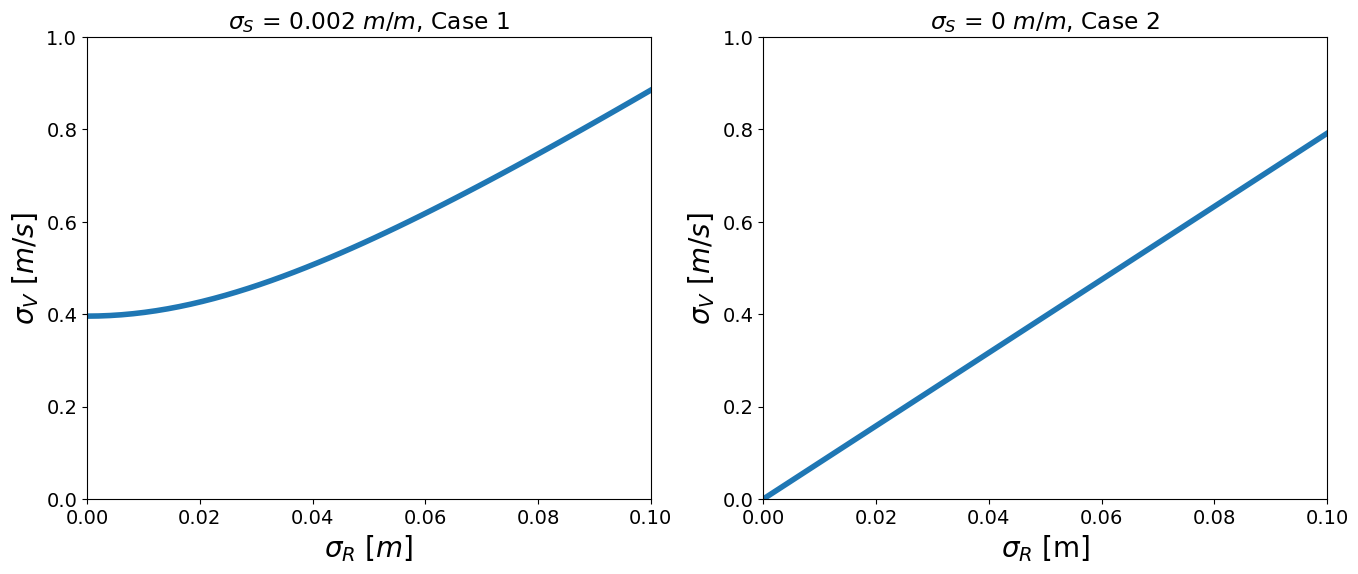

In [3]:
n = 0.013
mu_R = 0.5
mu_S = 0.015
sigma_R = np.linspace(0.0, 0.1, 50)

# case 1 for sigma_S
sigma_S_1 = 0.002
mu_V_1, sigma_V_1 = moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S_1, n)

# case 2 for sigma_S
sigma_S_2 = 0
mu_V_2, sigma_V_2 = moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S_2, n)

fig, ax = plt.subplots(1, 2, figsize = (16, 6))
# left side plot for case 1 
ax[0].plot(sigma_R, sigma_V_1, linewidth=4)
ax[0].set_ylabel(r'$\sigma_V$ [$m/s$]', size = 20)
ax[0].set_xlabel(r'$\sigma_R$ [$m$]', size = 20)
ax[0].set_title(r'$\sigma_S$ = ' + f'{sigma_S_1} $m/m$, Case 1')
ax[0].set_xlim(0, 0.1)
ax[0].set_ylim(0, 1)
# right side plot for case 2
ax[1].plot(sigma_R, sigma_V_2, linewidth=4)
ax[1].set_ylabel(r'$\sigma_V$ [$m/s$]', size = 20)
ax[1].set_xlabel(r'$\sigma_R$ [m]', size = 20)
ax[1].set_title(r'$\sigma_S$ = ' + f'{sigma_S_2} $m/m$, Case 2')
ax[1].set_xlim(0, 0.1)
ax[1].set_ylim(0, 1)
plt.show()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3:</b>   
Interpret the figures above, specifically looking at differences between Case 1 and Case 2. Also look at the equations you derived to understand why for Case 1 we get a non-linear relation, and for Case 2 a linear one.
</p>
</div>

_You can write an answer in this cell using Markdown._

## Part 2: Simulation-Based Propagation 

We will use again the following values:
- $\mu_R = 0.5$ m
- $\mu_S = 0.015$ m/m
- $\sigma_R=0.05$ m
- $\sigma_S=0.002$ m/m

Furthermore, it is assumed that $R$ and $S$ are independent normally distributed random variables. We will generate at least 10,000 simulated realizations each of $R$ and $S$ using a random number generator, and then you need to use these to calculate the corresponding sample values of $V$ and find the moments of that sample.


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1:</b>   
Complete the functions <code>function_of_random_variables</code> and <code>get_samples</code> below to define the function of random variables and then generate a sample of the output from this function, assuming the inputs are also random variables with the Normal distribution. Then find the moments of the samples.
</p>
</div>

In [4]:
def function_of_random_variables(R, S):
    V = (1/n)*(R**(2/3))*(S**(1/2))
    return V

def get_samples(N, sigma_R, mu_R=0.5, mu_S=0.015, sigma_S=0.002, n=0.013):
    """Generate random samples for V from R and S."""
    R = np.random.normal(mu_R, sigma_R, N)
    S = np.random.normal(mu_S, sigma_S, N)
    V = function_of_random_variables(R,S)
    return V

V_samples = get_samples(10000, 0.05)

mu_V_samples = V_samples.mean()
sigma_V_samples = V_samples.std()

print('Moments of the SAMPLES:')
print(f'  {mu_V_samples:.4f} m/s is the mean, and')
print(f'  {sigma_V_samples:.4f} m/s is the std dev.')

mu_V_taylor, sigma_V_taylor = moments_of_taylor_approximation(mu_R, mu_S, 0.05, 0.002, n)
print('\nMoments of the TAYLOR SERIES APPROXIMATION:')
print(f'  {mu_V_taylor:.4f} m/s is the mean, and')
print(f'  {sigma_V_taylor:.4f} m/s is the std dev.')

Moments of the SAMPLES:
  5.9161 m/s is the mean, and
  0.5585 m/s is the std dev.

Moments of the TAYLOR SERIES APPROXIMATION:
  5.9151 m/s is the mean, and
  0.5596 m/s is the std dev.


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\textbf{Task 2.2:}$   
Are the results similar for the linearized and simulated values? Describe the difference quantitatively. Check your result also for the range of values of $\sigma_R$ from 0.01 to 0.10; are they consistent?
</div>

_You can write an answer in this cell using Markdown._

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\textbf{Task 2.3:}$   
Run the cell with the sampling algorithm above repeatedly and look at the values printed in the cell output. Which values change? Which values do <em>not</em> change? Explain why, in each case.
</div>

_You can write an answer in this cell using Markdown._

## Part 3: Validating the Moments with a Distribution

In Part 2 we used a sample of the function of random variables to _validate_ the Taylor approximation (we found that they are generally well-approximated). Now we will assume that the function of random variables has the Normal distribution to validate the moments and see for which range of values they remain a good approximation. This is done by comparing the sample to the assumed distribution; the former is represented by a histogram (also called an empirical probability density function, PDF, when normalized), the latter by a Normal distribution with moments calculated using the Taylor approximation.

We will also use a normal probability plot to assess how well the assumption that $V$ is normally distributed holds up while varying the value of $\sigma_R$, introduced next.

### Theoretical Quantiles with `probplot`

The method `probplot` is built into `scipy.stats` (Documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)) and _validates_ a probability model by comparing samples (i.e., data) to a theoretical distribution (in this case, Normal). The "Theoretical quantile" that is plotted on the x-axis of this plot and measures the distance from the median of a distribution, normalized by the standard deviation, such that $\mathrm{quantile}=q\cdot\sigma$. For example, $q=-1.5$ is $\mu-1.5\cdot\sigma$. The vertical axis is the value of the random variable.

Because we are comparing a theoretical distribution and a sample (data) on the same plot, one of the lines is the Normal PDF, which of course will have an exact match with the _theoretical quantiles_. This is why the Normal PDF will plot as a straight line in `probplot`. Comparing the (vertical) distance between the samples and the theoretical distribution (the red line) allows us to _validate_ our model. In particular, it allows us to validate the model for different regions of the distribution. In your interpretation, for example, you should try and identify whether the model is a good fit for the center and/or tails of the distribution.

Note that `probplot` needs to know what to use for samples (you will tell it this), and what type of theoretical distribution you are using (we already did this for you...`norm`).

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
Complete the function <code>validate_distribution</code> below (instructions are in the docstring) to plot the empirical probability density function (PDF) of $V$ using your simulated samples. Also plot the Normal PDF in the same figure using the moments computed from the error propagation law. 
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p><em>Hint: if you are struggling with the code below, re-read the introduction to Part 3 carefully!</em></p></div>

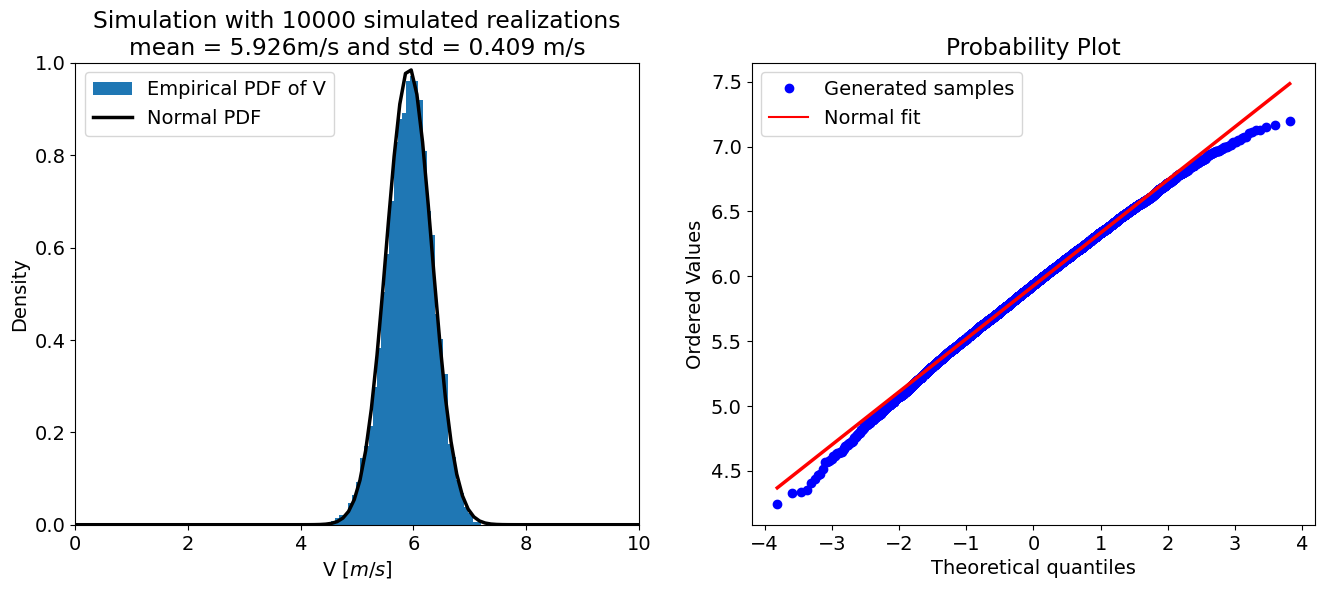

In [6]:
def validate_distribution(N, sigma_R, mu_R=0.5, mu_S=0.015, sigma_S=0.002, n=0.013):
    """Generate samples and plots for V
    
    Compares the sampled distribution of V to a Normal distribution defined
    by the first moments of the error propagation law.
    
    Comparison is made via two plots:
      1. PDF of V~N(mu,sigma) (the approximation) and a histogram (sample)
      2. Probability plot, compares quantiles of sample and CDF of V
    
    Only a plot is returned.
    
    MUDE students fill in the missing code (see: YOUR_CODE_HERE):
      1. Generate samples and find moments
      2. Find moments of the function of random variables using Taylor series
      3. Enter data for the histogram
      4. Define the moments of the Normal distribution to be plotted
      5. Identify the appropriate variables to be printed in the plot titles
      6. Enter the data required for the probability plot
    """
    
    # Generate a sample and compute moments
    V_samples = get_samples(N, sigma_R)
    mu_V_samples = V_samples.mean()
    sigma_V_samples = V_samples.std()
    
    # Compute moments using Taylor
    mu_V_taylor, sigma_V_taylor = moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S, n)
    # Create left-side plot with histogram and normal distribution
    # Plot histogram
    xmin = 0
    xmax = 10
    x = np.linspace(xmin, xmax, 100)
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    
    ax[0].hist(V_samples, bins = 40, density = True, 
               label = 'Empirical PDF of V')
    
    # Add normal pdf in same figure
    ax[0].plot(x, norm.pdf(x, mu_V_taylor, sigma_V_taylor), color = 'black',
               lw = 2.5, label='Normal PDF')

    ax[0].legend()
    ax[0].set_xlabel('V [$m/s$]')
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Density')
    ax[0].set_title(f'Simulation with {N} simulated realizations'
                    + '\n' + f'mean = {round(mu_V_samples, 3)}' 
                    f'm/s and std = {round(sigma_V_samples, 3)} m/s')
    
    # Add probability plot in right-side panel
    probplot(V_samples, dist = norm, fit = True, plot = ax[1])

    ax[1].legend(['Generated samples', 'Normal fit'])
    ax[1].get_lines()[1].set_linewidth(2.5)
    plt.show()

validate_distribution(10000, 0.01)

### Validate the Distribution of $V$ for Various $\sigma_R$

The code below uses a widget to call your function to make the plots and add a slider to change the values of $\sigma_R$ and visualize the change in the distributions.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\textbf{Task 3.2:}$
Run the cell below, then play with the slider to change $\sigma_R$. How well does the error propagation law match the "true" distribution (the samples)? State your conclusion and explain why. Check also whether there is an impact for different $\sigma_R$ values.
</p>
</div>

In [7]:
@interact(sigma_R=(0, 0.1, 0.005))
def samples_slideplot(sigma_R):
    validate_distribution(50000, sigma_R);

interactive(children=(FloatSlider(value=0.05, description='sigma_R', max=0.1, step=0.005), Output()), _dom_cla…

_You can write an answer in this cell using Markdown._

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\textbf{Task 3.3:}$
To further validate the error propagation law, estimate the probability that the "true" velocity of the tunnel is in the inaccurate range of values (assuming that the Normal distribution is a suitable model for the distribution of the function of random variables).

<em>Hint: recall that in this notebook a quantile, $q$, is defined as a standard deviation, and that the probability of observing a random variable $X$ such that $P[X\lt q]$ can be found with the CDF of the standard Normal distribution, evaluated in Python using <code>scipy.stats.norm.cdf(q)</code>.</em>
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p><em>

$\textbf{Note:}$
As we saw in 3.2, the Normal distribution does not fit the tails of the distribution of the function of random variables perfectly. Although this means using the Normal distribution may not be a good way of estimating the probability of "being in the tails," the approach in this Task is still suitable for getting an idea of the order of magnitude, and observing how sever this "error" maybe for different assumptions of $\sigma_R$.</em></p></div>

In [9]:
p = 2*norm.cdf(-3)

print(f'The probability is {p:0.6e}')

# extra solution
print(f'The probability is {2*norm.cdf(-2.5):0.6e} for sigma_R = 0.01')
print(f'The probability is {2*norm.cdf(-3.0):0.6e} for sigma_R = 0.05')
print(f'The probability is {2*norm.cdf(-3.5):0.6e} for sigma_R = 0.10')

The probability is 2.699796e-03
The probability is 1.241933e-02 for sigma_R = 0.01
The probability is 2.699796e-03 for sigma_R = 0.05
The probability is 4.652582e-04 for sigma_R = 0.10


_You can write an answer in this cell using Markdown._

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.